In [2]:
from jax import config

config.update("jax_enable_x64", True)
import sys
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from jax import grad, hessian, jit
from jaxtyping import Array, Float, install_import_hook
from matplotlib import rcParams
from tqdm.notebook import tqdm

sys.path.append("src")
from kernels.ArtificialKernel import ArtificialKernel
from kernels.DiagonalKernel import DiagonalKernel
from kernels.DivFreeKernel import DivFreeKernel
from kernels.DivFreeKernelMatern import DivFreeKernelMatern
from utils.data_tools import generate_data, transform_data, regular_train_points, add_collocation_points
from utils.performance import rmse
from utils.plotting_tools import plot_data, plot_pred

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]

import toml

params = toml.load("params.toml")["2D"]
a = params["a"]
noise = params["noise"]
N_train = params["N_train"]
N_test_1D = params["N_test_1D"]
N_c_list = params["N_c_list"]

## Dataset

With the necessary modules imported, we simulate a dataset
$\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(\boldsymbol x_i, \boldsymbol y_i)\}_{i=1}^{400}$ with inputs $\boldsymbol{x}$
sampled uniformly on $[0, 4]\times [0,4]$ and corresponding independent noisy outputs

$$
\begin{aligned}
& f_1\left(x_1, x_2\right)=e^{-a x_1 x_2}\left(a x_1 \sin \left(x_1 x_2\right)-x_1 \cos \left(x_1 x_2\right)\right) \\
& f_2\left(x_1, x_2\right)=e^{-a x_1 x_2}\left(x_2 \cos \left(x_1 x_2\right)-a x_2 \sin \left(x_1 x_2\right)\right)
\end{aligned}
$$

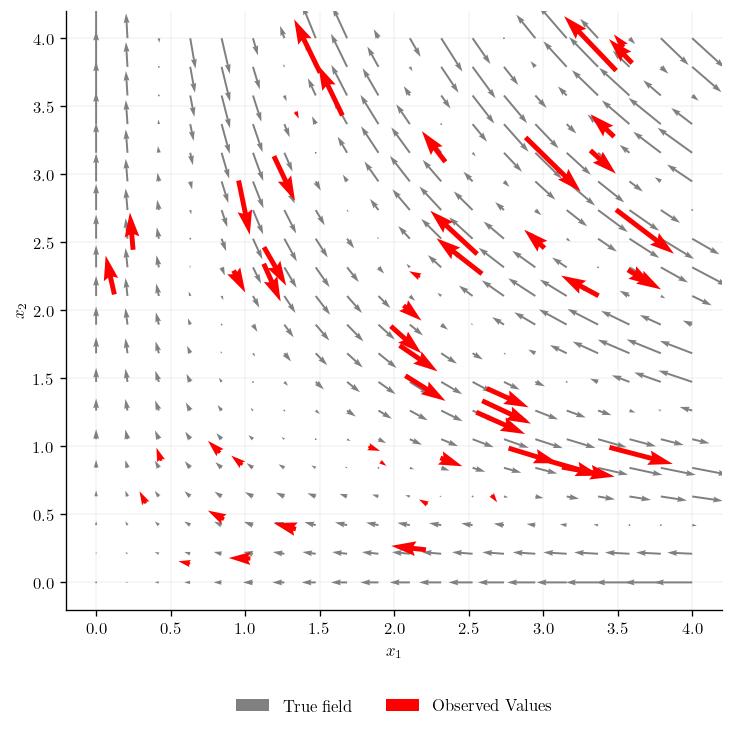

In [6]:
n = 50 # number of training points
N_test_1D = 20 # number of test points in 1D
N_P = N_test_1D**2 # total number of test points

master_key = jr.key(0)

x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,1e-1)
# x,y = regular_train_points(key = master_key, n=n, noise=noise)

# Plot the training and test data in a quiver plot
plot_data(x,y,xtest,ytest, "test2")

In [1]:
# Real points
dataset_train, dataset_test = transform_data(x,y,xtest,ytest)
dataset_coll_train_75 = add_collocation_points(dataset_train, xtest, 75, master_key)
dataset_coll_train_400 = add_collocation_points(dataset_train, xtest, 400, master_key)

NameError: name 'transform_data' is not defined

Note that there is tonnes of redundant calculation being done in these kernels!!
- The whole covariance is being calculated, where you only need one element (e.g. k22)
- In both the Hessian and Grad calculations, the whole vector is being calculated and only one element is indexed. In the case of a Hessian, a (2,2) tensor is made, and only one element is used!

# Testing the kernel

The first cell compares elements of the kernel to the analytic expressions of the various derivatives.
The second cell computes the full K matrix for train points (make sure there are only two train points!)

In [2]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([noise+1e-6], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

def optimise_mll(posterior, dataset, NIters=1000, verbose=True):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
        max_iters=NIters,
        verbose = verbose
    )
    if verbose:
        print("Length of history:",len(history))
    # print(history)
    return opt_posterior

In [3]:
from jax.tree_util import tree_structure
from jax.flatten_util import ravel_pytree

from gpjax.distributions import GaussianDistribution

def get_posterior(kernel,dataset_train, verbose = False, params = False):
    """Predicts the latent function at the test points given the training data and the kernel.

    Args:
        kernel (gpx kernel): Kernel
        dataset_train (jnp.ndarray): Training data
        test_X (jnp.ndarray): Test inputs

    Returns:
        jnp.ndarray: Output of the latent function at the test points
    """
    meanf = gpx.mean_functions.Zero()
    posterior = initialise_gp(kernel, meanf, dataset_train)
    opt_posterior = optimise_mll(posterior, dataset_train, verbose = verbose)

    if verbose:
        _params = ravel_pytree(posterior)[0].tolist()
        _params[2] = _params[2]**0.5 
        objective = gpx.objectives.ConjugateMLL(negative=True)
        print("Initial: σ_n, l, σ_f:", _params)
        print("Initial MLL:", objective(posterior, dataset_train))
        _params = ravel_pytree(opt_posterior)[0].tolist()
        _params[2] = _params[2]**0.5 
        print("Final: σ_n, l, σ_f:", _params)
        print("Final MLL:", objective(opt_posterior, dataset_train))
    if params:
        return opt_posterior, ravel_pytree(opt_posterior)[0]
    return opt_posterior

def latent_distribution(opt_posterior, pos_3d, dataset_train):
    latent = opt_posterior.predict(pos_3d, train_data=dataset_train)
    latent_mean = latent.mean()
    latent_std = latent.stddev()
    return latent_mean, latent_std

def predict(opt_posterior, test_X, dataset_train):
    pred_mean, _ = latent_distribution(
        opt_posterior, test_X, dataset_train
    )
    function_pred = pred_mean[test_X[:,2]!=2.0].reshape(-1,2,order="F")
    return function_pred

def steal_diag_params(diag_params, dataset_coll_train):
    meanf = gpx.mean_functions.Zero()
    art_posterior = initialise_gp(ArtificialKernel(), meanf, dataset_coll_train)
    ravel_func = ravel_pytree(art_posterior)[1]
    opt_art_posterior = ravel_func(diag_params)
    return opt_art_posterior


In [4]:
predictions = {}

In [7]:
opt_posterior_diag = get_posterior(DiagonalKernel(),dataset_train, verbose = True)
predictions.update({"Diagonal Kernel":predict(opt_posterior_diag,dataset_test.X,dataset_train)})

Optimization terminated successfully.
         Current function value: 148.543911
         Iterations: 43
         Function evaluations: 47
         Gradient evaluations: 47
Length of history: 44
Initial: σ_n, l, σ_f: [0.000101, 0.5, 0.7071067811865476]
Initial MLL: 468.3066258497635
Final: σ_n, l, σ_f: [3.1781681731802526e-07, 0.45861688467190925, 1.9388329436498708]
Final MLL: 148.54391102715863


In [8]:
opt_posterior_cust = get_posterior(DivFreeKernel(),dataset_train)
predictions.update({"DivFree Kernel":predict(opt_posterior_cust,dataset_test.X,dataset_train)})


In [9]:
# opt_posterior_art_75 = get_posterior(ArtificialKernel(),dataset_coll_train_75)
# predictions.update({"Artificial Kernel, 75 collocation points":predict(opt_posterior_art_75,dataset_test.X,dataset_coll_train_75)})
# opt_posterior_art_400 = get_posterior(ArtificialKernel(),dataset_coll_train_400)
# predictions.update({"Artificial Kernel, 400 collocation points":predict(opt_posterior_art_400,dataset_test.X,dataset_coll_train_400)})

In [10]:
opt_posterior_cust = get_posterior(DivFreeKernelMatern(),dataset_train)
predictions.update({"DivFree Kernel Matern":predict(opt_posterior_cust,dataset_test.X,dataset_train)})

TypeError: array() got an unexpected keyword argument 'dtypes'

c:\Users\neelm\OneDrive\GitHub\Private\Data Intensive Science\Diss\nm741\src\utils\plotting_tools.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


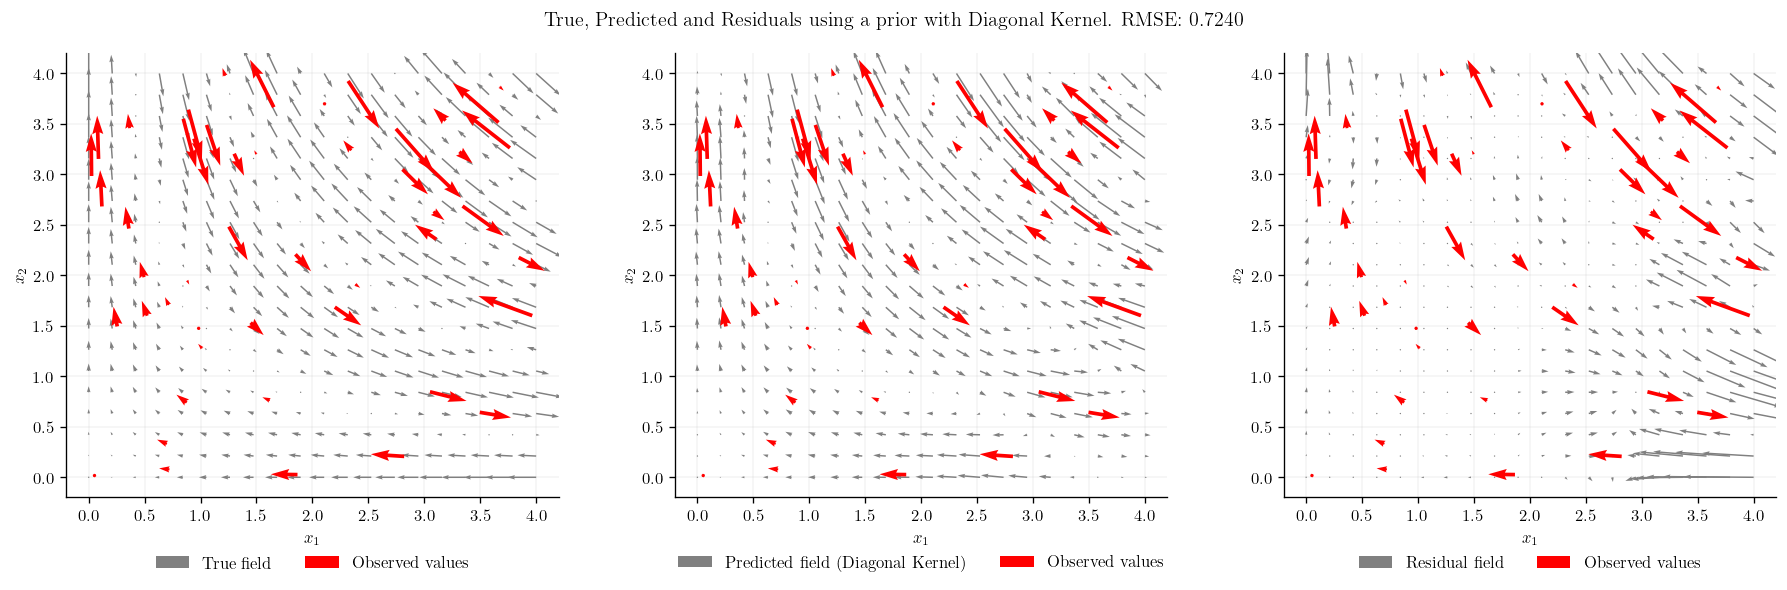

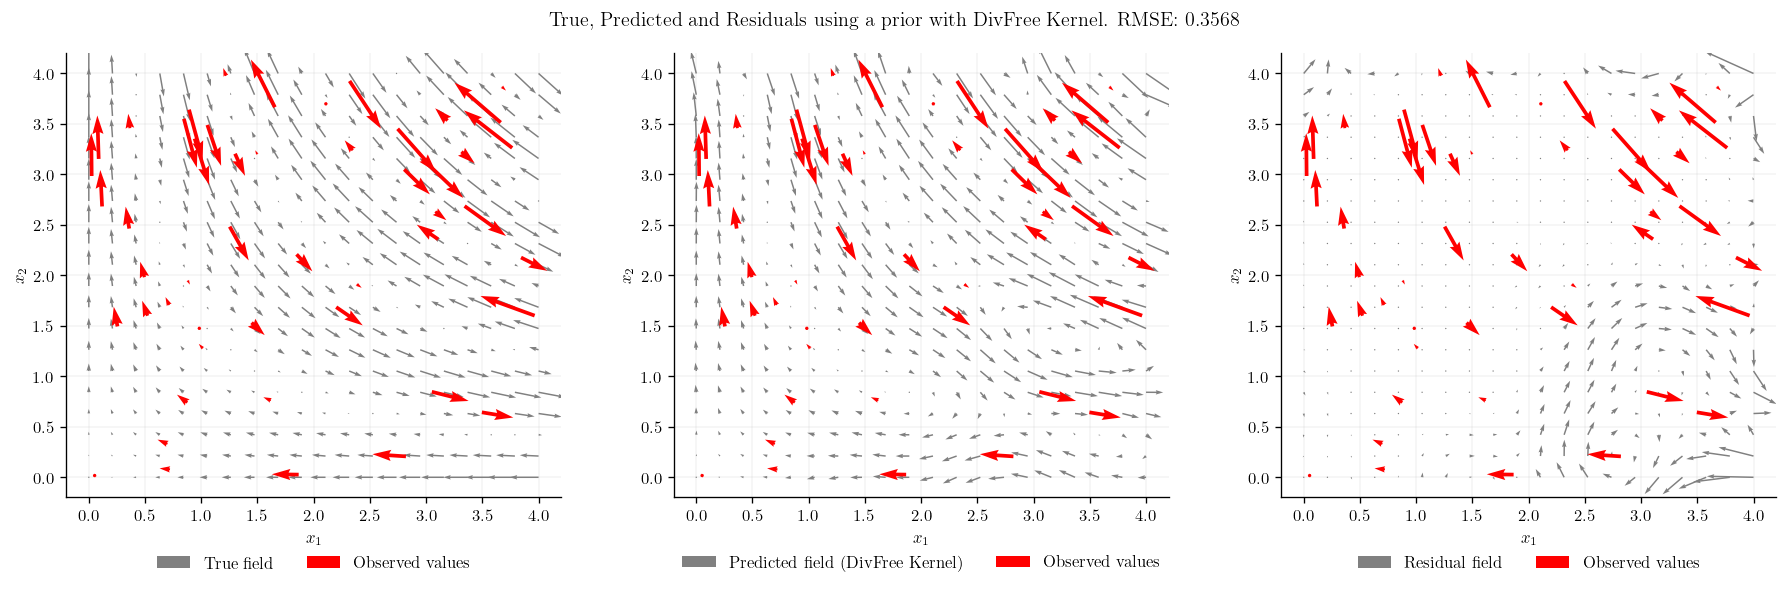

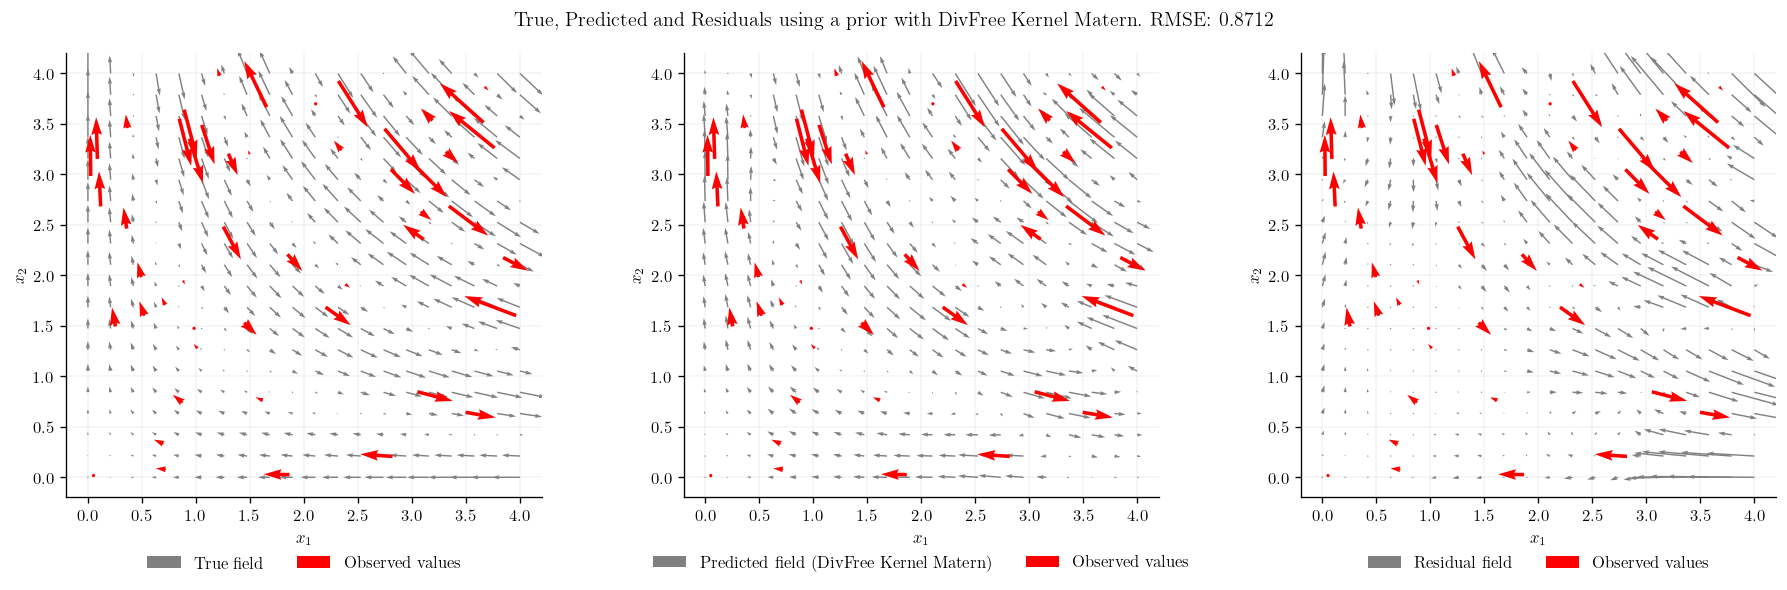

In [ ]:
for kernel_name,ypred in predictions.items():
    plot_pred(x,y,xtest,ytest,ypred,kernel_name=kernel_name)

In [ ]:
import numpy as np

N_c_list = [25, 50, 75, 100, 150, 200, 300, 400]

nrRepeat = 50
errDiag_all=np.zeros((nrRepeat,1))
errCust_all=np.zeros((nrRepeat,1))
errDiagObs_all=np.zeros((nrRepeat,len(N_c_list)))
L_opt_diag_all = np.zeros((nrRepeat,1))
L_opt_cust_all = np.zeros((nrRepeat,1))
L_opt_diagObs_all = np.zeros((nrRepeat,len(N_c_list)))

noise = 1e-4
if nrRepeat == 1:
    verbose = True
else:
    verbose = False

train_artificial_posterior = True
    

for i in tqdm(range(nrRepeat), desc = f"Repeating experiment {nrRepeat} times"):
    ## Set seed
    master_key = jr.key(i)

    ## Get data
    x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    ## Turn on if you want to use regular training points
    # x,y = regular_train_points(master_key, a=a, n=n, noise=noise)
    dataset_train, dataset_test = transform_data(x,y,xtest,ytest,master_key)
    
    ## Diagonal Kernel
    if verbose: print("\nDiagonalKernel\n-------------------")
    opt_posterior_diag, diag_params = get_posterior(DiagonalKernel(),dataset_train, verbose = verbose, params=True) 
    objective = gpx.objectives.ConjugateMLL(negative=True)
    MLL = objective(opt_posterior_diag, dataset_train)
    L_opt_diag_all[i] = MLL.item()
    ypred = predict(opt_posterior_diag,dataset_test.X,dataset_train)
    errDiag_all[i] = rmse(ytest,ypred).item()
    if verbose: print("Diagonal Kernel rmse:", rmse(ytest,ypred).item())

    ## Divergence-free Kernel
    if verbose: print("\nDivFreeKernel\n-------------------")
    opt_posterior_cust = get_posterior(DivFreeKernel(),dataset_train, verbose = verbose)
    objective = gpx.objectives.ConjugateMLL(negative=True)
    MLL = objective(opt_posterior_cust, dataset_train)
    L_opt_cust_all[i] = MLL.item()
    ypred = predict(opt_posterior_cust,dataset_test.X,dataset_train)
    errCust_all[i] = rmse(ytest,ypred).item()
    if verbose: print("DivFree Kernel rmse:", rmse(ytest,ypred).item())
    
    ## Artificial Kernel
    for j,N_c in enumerate(N_c_list):
        if verbose: print(f"\nArtificialKernel, N_c = {N_c}\n-------------------")
        dataset_coll_train = add_collocation_points(dataset_train, xtest, N_c, master_key)
        if train_artificial_posterior:
            opt_posterior_art = get_posterior(ArtificialKernel(),dataset_coll_train, verbose = verbose)
        else:
            opt_posterior_art = steal_diag_params(diag_params, dataset_coll_train)
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_art, dataset_coll_train)
        L_opt_diagObs_all[i,j] = MLL.item()
        ypred = predict(opt_posterior_art,dataset_test.X,dataset_coll_train)
        errDiagObs_all[i,j] = rmse(ytest,ypred).item()
        if verbose: print(f"Artificial Kernel, N_c = {N_c} rmse:", rmse(ytest,ypred).item())
    

In [ ]:
import numpy as np
from os.path import join, exists
import os

if train_artificial_posterior:
    directory = "results/Trained Artificial Posterior 3"
else:
    directory = "results/Stolen Artificial Posterior 2"

# Define a dictionary to store the arrays
arrays = {
    'L_opt_cust_all': L_opt_cust_all,
    'L_opt_diagObs_all': L_opt_diagObs_all,
    'L_opt_diag_all': L_opt_diag_all,
    'errCust_all': errCust_all,
    'errDiagObs_all': errDiagObs_all,
    'errDiag_all': errDiag_all
}


if not exists(directory):
    os.makedirs(directory)

# Save the arrays
for name, array in arrays.items():
    np.save(join(directory,f'{name}.npy'), array)



In [ ]:
# Plot MLL
plt.figure(figsize=(10,5))
plt.errorbar(N_c_list, L_opt_diagObs_all.mean(axis=0), yerr=L_opt_diagObs_all.std(axis=0), fmt='o-', label='Artificial Kernel')

In [ ]:
print("Mean", np.mean(testDiag_all))
print("Standard deviation", np.std(testDiag_all))

Visually, the Helmholtz model performs better than the velocity model, preserving the local structure of the $\mathbf{F}$. Since we placed priors on $\Phi$ and $\Psi$, the construction of $\mathbf{F}$ allows for correlations between the dimensions (non-zero off-diagonal elements in the Gram matrix populated by $k_\text{Helm}\left(\mathbf{X},\mathbf{X}^{\prime}\right)$ ).

## Negative log predictive densities
Lastly, we directly compare the velocity and Helmholtz models by computing the [negative log predictive densities](https://en.wikipedia.org/wiki/Negative_log_predictive_density) for each model. This is a quantitative metric that measures the probability of the ground truth given the data.

$$
\mathrm{NLPD}=-\sum_{i=1}^{2N} \log \left(  p\left(\mathcal{Y}_i = Y_{0,i} \mid \mathbf{X}_{i}\right) \right),
$$

where each $p\left(\mathcal{Y}_i \mid \mathbf{X}_i \right)$ is the marginal Gaussian distribution over $\mathcal{Y}_i$ at each test location, and $Y_{i,0}$ is the $i$-th component of the (massaged) test data that we reserved at the beginning of the notebook in $D_0$. A smaller value is better, since the deviation of the ground truth and the model are small in this case.

In [ ]:
%load_ext line_profiler
%lprun -f optimise_mll optimise_mll(posterior, dataset_train)

In [ ]:

import numpy as np

N_c_list = [25, 50, 75, 100, 150, 200, 300, 400]

nrRepeat = 5
errDiag_all=np.zeros((nrRepeat,1))
errCust_all=np.zeros((nrRepeat,1))
errDiagObs_all=np.zeros((nrRepeat,len(N_c_list)))
L_opt_diag_all = np.zeros((nrRepeat,1))
L_opt_cust_all = np.zeros((nrRepeat,1))
L_opt_diagObs_all = np.zeros((nrRepeat,len(N_c_list)))

noise = 1e-4
if nrRepeat == 1:
    verbose = True
else:
    verbose = False

def lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose):
    for i in tqdm(range(nrRepeat), desc = f"Repeating experiment {nrRepeat} times"):
    ## Set seed
        master_key = jr.key(i)

    ## Get data
        x,y,xtest,ytest = generate_data(master_key,a,n,N_test_1D,noise)
    ## Turn on if you want to use regular training points
    # x,y = regular_train_points(master_key, a=a, n=n, noise=noise)
        dataset_train, dataset_test = transform_data(x,y,xtest,ytest,master_key)
    
    ## Diagonal Kernel
        opt_posterior_diag, diag_params = get_posterior(DiagonalKernel(),dataset_train, verbose = verbose, params=True) 
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_diag, dataset_train)
        L_opt_diag_all[i] = MLL.item()
        ypred = predict(opt_posterior_diag,dataset_test.X,dataset_train)
        errDiag_all[i] = rmse(ytest,ypred).item()

    ## Divergence-free Kernel
        opt_posterior_cust = get_posterior(DivFreeKernel(),dataset_train, verbose = verbose)
        objective = gpx.objectives.ConjugateMLL(negative=True)
        MLL = objective(opt_posterior_cust, dataset_train)
        L_opt_cust_all[i] = MLL.item()
        ypred = predict(opt_posterior_cust,dataset_test.X,dataset_train)
        errCust_all[i] = rmse(ytest,ypred).item()
    
    ## Artificial Kernel
        for j,N_c in tqdm(enumerate(N_c_list), desc = f"ArtifKernel with {len(N_c_list)} different N_c values", leave = False, total = len(N_c_list)):
            dataset_coll_train = add_collocation_points(dataset_train, xtest, N_c, master_key)
            opt_posterior_art = steal_diag_params(diag_params, dataset_coll_train)

        ## If you want to train the artificial kernel
        # opt_posterior = get_posterior(ArtificialKernel(),dataset_coll_train, verbose = verbose)
            objective = gpx.objectives.ConjugateMLL(negative=True)
            MLL = objective(opt_posterior_art, dataset_coll_train)
            L_opt_diagObs_all[i,j] = MLL.item()
            ypred = predict(opt_posterior_art,dataset_test.X,dataset_coll_train)
            errDiagObs_all[i,j] = rmse(ytest,ypred).item()

In [ ]:
# %load_ext line_profiler
# %lprun -f lp_func lp_func(N_c_list, nrRepeat, errDiag_all, errCust_all, errDiagObs_all, L_opt_diag_all, L_opt_cust_all, L_opt_diagObs_all, noise, verbose)

In [ ]:
# ensure testing data alternates between x0 and x1 components
def nlpd(mean, std, vel_test):
    vel_query = jnp.column_stack((vel_test[0], vel_test[1])).flatten()
    normal = tfp.substrates.jax.distributions.Normal(loc=mean, scale=std)
    return -jnp.sum(normal.log_prob(vel_query))


# compute nlpd for velocity and helmholtz
nlpd_vel = nlpd(velocity_mean, velocity_std, ytest)
nlpd_helm = nlpd(helmholtz_mean, helmholtz_std, ytest)

print("NLPD for Velocity: %.2f \nNLPD for Helmholtz: %.2f" % (nlpd_vel, nlpd_helm))

In [ ]:

# diag = DiagonalKernel()
# print(diag(dataset_train.X[0], dataset_train.X[2]))
# print(diag(dataset_coll_train.X[0], dataset_coll_train.X[3]))

# rbf = gpx.kernels.RBF(active_dims=[0,1])
# print(rbf(dataset_train.X[0], dataset_train.X[2]))

z0=dataset_coll_train.X[1]
z1=dataset_coll_train.X[5]
v0=z0[:-1]
v1=z1[:-1]
print(z0,z1)

def k00(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return expo

def k20(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return -(x[0]-xp[0]) * expo

def k21(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return -(x[1]-xp[1]) * expo

def k22(x,xp):
    expo = jnp.exp(-0.5 * jnp.sum((x-xp)**2))
    return (2 - (x[0]-xp[0])**2
              - (x[1]-xp[1])**2) * expo 

der = ArtificialKernel()
print(der(z0, z1))
print("----------------------")
print(k00(v0, v1))
print(k20(v0, v1))
print(k21(v0, v1))
print(k22(v0, v1))